In [1]:
import numpy as np
import matplotlib.pyplot as plt
import string
import os
import pickle
from PIL import Image
import glob
from pickle import dump, load
from time import time
import keras
from keras.layers import LSTM, Embedding, Dense, Dropout
from keras.layers.merge import add
from keras.preprocessing import image
from keras.models import Model
from keras import Input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from nltk.translate.bleu_score import corpus_bleu

In [2]:
def text_file(text_path):
    filename = open(text_path,'r')
    file = filename.read()
    filename.close()
    return file

text_path = 'Flickr8k.token.txt'
file = text_file(text_path)
print(file[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [3]:
def dic_create_text(file):
    
    text_data = dict()
    for text in file.split('\n'):
        
        if(len(text) <2 ):
            continue
        ID_caption = text.split()
        ID, caption = ID_caption[0],ID_caption[1:]
        ID = ID.split('.')[0]
        #print(ID,' '.join(caption))
        text_data.setdefault(ID, [])
        text_data[ID].append(' '.join(caption))
        
    return text_data

text_dictionary = dic_create_text(file)
print('Loaded: %d ' % len(text_dictionary))

Loaded: 8092 


In [4]:
def data_cleaning(text_dictionary): 
    extras = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', 
             ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']
    
    removals = str.maketrans('', '', ''.join(extras))
    #removals = str.maketrans('', '', string.punctuation)
    for key,values in text_dictionary.items():
        for i in range(len(values)):
            v = values[i]
            words = v.split(' ')
            words = [ i.lower() for i in words]
            words = [ i.translate(removals) for i in words]
            words = [ i for i in words if i.isalpha()]
            words = [ i for i in words if len(i) >1]

            
            values[i] = ' '.join(words)
            
data_cleaning(text_dictionary)

In [5]:
vocabulary = set()
def create_vocabulary(text_dictionary):
    vocabulary = set()
    for items in text_dictionary.keys():
        for sentence in text_dictionary[items]:
            vocabulary.update(sentence.split())
    return vocabulary
        
vocabulary = create_vocabulary(text_dictionary)
print(len(vocabulary))

8763


In [6]:
def save_text_dictionary(text_dictionary, filename):
    sentences = list()
    for key, values in text_dictionary.items():
        for sentence in values:
            sentences.append(key + ' ' + sentence)
    data = '\n'.join(sentences)
    file = open(filename, 'w')
    file.write(data)
    file.close()
filepath = 'text_dictionary.txt'
save_text_dictionary(text_dictionary, filepath)

In [7]:
def creating_dataset(filepath):
    file = text_file(filepath)
    data = []
    for text in file.split('\n'):
        
        if(len(text) <1 ):
            continue
        ID_caption = text.split()
        ID = ID_caption[0]
        ID = ID.split('.')[0]
        #print(ID,' '.join(caption))
        data.append(ID)
        
    return set(data)
filepath = 'Flickr_8k.trainImages.txt'
training_data = creating_dataset(filepath)
print(len(training_data))

6000


In [8]:
image_path = 'Flicker8k_Dataset/'
list_images  = glob.glob(image_path + '*.jpg')

In [9]:
train_images_file = 'Flickr_8k.trainImages.txt'
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))#
train_img = []

for i in list_images:
    if i[len(image_path):] in train_images: 
        train_img.append(i)

In [10]:
test_images_file = 'Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))
test_img = []

for i in list_images:
    if i[len(image_path):] in test_images:
        test_img.append(i) 

In [11]:
def load_clean_descriptions(filename, dataset):
    doc = text_file(filename)
    sentences = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in sentences:
                sentences[image_id] = list()
            desc = 'SOS ' + ' '.join(image_desc) + ' EOS'
            sentences[image_id].append(desc)
    return sentences

train_descriptions = load_clean_descriptions('text_dictionary.txt', training_data)
print(len(train_descriptions))

6000


In [ ]:
def preprocess(image_path):
    image1 = image.load_img(image_path, target_size=(299, 299))
    image2 = image.img_to_array(image1)
    image3 = np.expand_dims(image2, axis=0)
    image4 = preprocess_input(image3)
    return image4

In [ ]:
model = InceptionV3(weights='imagenet')

In [ ]:
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) 
    return fea_vec

In [ ]:
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)

In [ ]:
with open("features_flickr_8k_train.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [ ]:
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)

In [ ]:
with open("features_flickr_8k_test.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [12]:
train_features = load(open("features_flickr_8k_train.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [13]:
train_features['1000268201_693b08cb0e.jpg']

array([0.12277637, 0.33293113, 0.7527251 , ..., 0.21941496, 0.30208495,
       0.40279624], dtype=float32)

In [14]:
Training_captions = []
for key, value in train_descriptions.items():
    for sentences in value:
        Training_captions.append(sentences)
len(Training_captions)

30000

In [15]:
threshold = 2
word_counts = {}
#number_of_sentences = 0
for sentences in Training_captions:
    #number_of_sentences += 1
    for words in sentences.split(' '):
        word_counts[words] = word_counts.get(words, 0) + 1

short_vocabulary = []
for word in word_counts:
    if word_counts[word] >= threshold:
        short_vocabulary.append(word)
print(len(word_counts), len(short_vocabulary))

7578 4473


In [16]:
indextoword = {}
wordtoindex = {}

index = 1
for word in short_vocabulary:
    wordtoindex[word] = index
    indextoword[index] = word
    index += 1


In [17]:
vocab_size = len(indextoword) + 1 # one for appended 0's
vocab_size

4474

In [18]:
def sentence_length(descriptions):
    sentences = []
    for key in descriptions.keys():
        [sentences.append(i) for i in descriptions[key]]
    return max(len(i.split()) for i in sentences)


sentence_length = sentence_length(train_descriptions)
print(sentence_length)

34


In [19]:
def data_generator(descriptions, train_features, wordtoindex, sentence_length, number):
    image_matrix = []
    input_matrix = []
    output_matrix = []
    count = 0

    while 1:
        for key, values in descriptions.items():
            count+=1

            image_vector = train_features[key+'.jpg']
            for desc in values:

                seq = [wordtoindex[word] for word in desc.split(' ') if word in wordtoindex]

                for i in range(1, len(seq)):

                    input_sequence, output_sequence = seq[:i], seq[i]
                    input_sequence = pad_sequences([input_sequence], maxlen=sentence_length)[0]
                    output_sequence = to_categorical([output_sequence], num_classes=vocab_size)[0]
                    image_matrix.append(image_vector)
                    input_matrix.append(input_sequence)
                    output_matrix.append(output_sequence)
            if count==number:
                yield [np.array(image_matrix), np.array(input_matrix)], np.array(output_matrix)
                image_matrix = []
                input_matrix = []
                output_matrix = []
                count = 0
            

In [ ]:
glove_dir = 'C:\\Users\\HP\Desktop\\Automatic-Image-Captioning-master\\Automatic-Image-Captioning-master'
f = open(os.path.join(glove_dir, 'glove.840B.300d.txt'), encoding="utf-8")

In [ ]:
c=1
embeddings_index = {} 
for line in f:
    word = ''
    try:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        print(c,len(line.split()))
    c+=1
print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
embedding_dim = 300

In [ ]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoindex.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
len(embedding_matrix)

In [ ]:
file = open('embedding_matrix_300d_1.txt','w')
listt = []
for i in range(embedding_matrix.shape[0]):
    listt.append('  '.join(str(j) for j in embedding_matrix[i]))
string = '\n'.join(listt)
# file.write(string)
file.close()

In [ ]:
embedding_matrix1 = []
filename = open('embedding_matrix_300d_1.txt','r')
file = filename.read()
i=0
for vector in file.split('\n'):
    if vector=='':
        break
    embedding_matrix1.append([float(j) for j in vector.split()])
    i+=1
embedding_matrix1 = np.array(embedding_matrix1)
print(embedding_matrix1.shape)
filename.close()

In [ ]:
input1 = Input(shape=(2048,))
layer1 = Dropout(0.5)(input1)
layer1 = Dense(256, activation='relu')(layer1)
input2 = Input(shape=(sentence_length,))
layer2 = Embedding(vocab_size, embedding_dim, mask_zero=True)(input2)
layer2 = Dropout(0.5)(layer2)
layer2 = LSTM(256)(layer2)
decoder = add([layer1, layer2])
decoder = Dense(256, activation='relu')(decoder)
outputs = Dense(vocab_size, activation='softmax')(decoder)
model = Model(inputs=[input1, input2], outputs=outputs)

In [ ]:
model.summary()

In [ ]:
model.layers[2]

In [ ]:
model.layers[2].set_weights([embedding_matrix1])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [ ]:
steps = len(train_descriptions)//3

In [ ]:
for i in range(10):
    generator = data_generator(train_descriptions, train_features, wordtoindex, sentence_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [ ]:
for i in range(10):
    generator = data_generator(train_descriptions, train_features, wordtoindex, sentence_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [ ]:
model.optimizer.lr = 0.0001
steps = len(train_descriptions)//6

In [ ]:
for i in range(10):
    generator = data_generator(train_descriptions, train_features, wordtoindex, sentence_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [ ]:
for i in range(10):
    generator = data_generator(train_descriptions, train_features, wordtoindex, sentence_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [20]:
model = keras.models.load_model('C:\\Users\\HP\\Desktop\\ML_Project_EM2')

In [21]:
imagepath = 'C:\\Users\\HP\\Desktop\\My project\\Flicker8k_Dataset\\'
test_features_dict = load(open("features_flickr_8k_test.pkl", "rb"))
text_dictionary_path = 'C:\\Users\\HP\\Desktop\\My project\\text_dictionary.txt'
test_dataset_path = 'C:\\Users\\HP\\Desktop\\My project\\Flickr_8k.testImages.txt'
#print('Photos: train=%d' % len(test_features))
#list(test_features_dict.keys())


In [22]:
test_dataset = creating_dataset(test_dataset_path)

In [23]:
def load_clean_descriptions(filename, dataset):
    doc = text_file(filename)
    sentences = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in sentences:
                sentences[image_id] = list()
            desc = ' '.join(image_desc)
            sentences[image_id].append(desc)
    return sentences

test_descriptions = load_clean_descriptions(text_dictionary_path, test_dataset)
#print((test_descriptions))

In [24]:
test_features_keys = list(test_features_dict.keys())

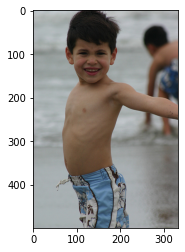

In [25]:
x=plt.imread(imagepath+test_features_keys[1])
plt.imshow(x)
plt.show()

In [26]:
def greedy_search(image):
    word = 'SOS'
    for i in range(sentence_length):
        sequence = [wordtoindex[w] for w in word.split() if w in wordtoindex]
        sequence = pad_sequences([sequence], maxlen=sentence_length)
        yhat = model.predict([image,sequence], verbose=0)
        #print(yhat[0].shape)
        yhat = np.argmax(yhat)
        ixtow = indextoword[yhat]
        word += ' ' + ixtow
        if ixtow == 'EOS':
            break
    word = word.split()
    word = word[1:-1]
    word = ' '.join(word)    
    return word

In [ ]:
len(test_features_dict)

In [ ]:
file = open('predictions_greedy.txt','w')
string = '\n'.join(list_sentences)
file.write(string)
file.close()

In [27]:
def string_list(file):
    list1 = []
    for sentence in file.split('\n'):
        list1.append(sentence)
    return list1

In [28]:
filepath = open('predictions_greedy.txt','r')
file = filepath.read()
list_sentences = string_list(file)
#print(list_sentences)

In [31]:
BLEU1 = []
BLEU2 = []
BLEU3 = []
BLEU4 = []

In [32]:
for i in range(1000):
    desc_list = test_descriptions[test_features_keys[i][:-4]]
    actual_list =  [d.split() for d in desc_list]
    predicted = list_sentences[i].split()
    BLEU1.append(corpus_bleu([actual_list], [predicted], weights=(1.0, 0, 0, 0)))
    BLEU2.append(corpus_bleu([actual_list], [predicted], weights=(0.5, 0.5, 0, 0)))
    BLEU3.append(corpus_bleu([actual_list], [predicted], weights=(0.33, .33, 0, 0.33, 0)))
    BLEU4.append(corpus_bleu([actual_list], [predicted], weights=(0.25, 0.25, 0.25, 0.25)))

In [33]:
print(sum(BLEU1)/1000,sum(BLEU2)/1000,sum(BLEU3)/1000,sum(BLEU4)/1000)

0.4280698538145306 0.21068181744394263 0.030728453374985157 0.02948267074944248


In [34]:
def beam_search_predictions(image, beam_index):
    start = [wordtoindex["SOS"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < sentence_length:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=sentence_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [indextoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'EOS':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
list_sentences_b_3 = []
list_sentences_b_5 = []
list_sentences_b_7 = []
list_sentences_b_10 = []
for i in range(1000):
    image = test_features_dict[test_features_keys[i]].reshape(1,2048)  
    list_sentences_b_3.append(beam_search_predictions(image,3))
    list_sentences_b_5.append(beam_search_predictions(image,5))
    list_sentences_b_7.append(beam_search_predictions(image,7))
    list_sentences_b_10.append(beam_search_predictions(image,10))
    print(i)


In [ ]:
file = open('predictions_beam_10.txt','w')
string = '\n'.join(list_sentences_b_10)
file.write(string)
file.close()

In [35]:
filepath = open('predictions_beam_3.txt','r')
file = filepath.read()
list_sentences_b_3 = string_list(file)

filepath = open('predictions_beam_5.txt','r')
file = filepath.read()
list_sentences_b_5 = string_list(file)

filepath = open('predictions_beam_7.txt','r')
file = filepath.read()
list_sentences_b_7 = string_list(file)

filepath = open('predictions_beam_10.txt','r')
file = filepath.read()
list_sentences_b_10 = string_list(file)
# print(list_sentences_b_3)

In [36]:
BLEU_1_3 = []
BLEU_2_3 = []
BLEU_3_3 = []
BLEU_4_3 = []
BLEU_1_5 = []
BLEU_2_5 = []
BLEU_3_5 = []
BLEU_4_5 = []
BLEU_1_7 = []
BLEU_2_7 = []
BLEU_3_7 = []
BLEU_4_7 = []
BLEU_1_10 = []
BLEU_2_10 = []
BLEU_3_10 = []
BLEU_4_10 = []

In [37]:
for i in range(1000):
    desc_list = test_descriptions[test_features_keys[i][:-4]]
    actual_list =  [d.split() for d in desc_list]
    predicted_3 = list_sentences_b_3[i].split()
    predicted_5 = list_sentences_b_5[i].split()
    predicted_7 = list_sentences_b_7[i].split()
    predicted_10 = list_sentences_b_10[i].split()
    BLEU_1_3.append(corpus_bleu([actual_list], [predicted_3], weights=(1.0, 0, 0, 0)))
    BLEU_2_3.append(corpus_bleu([actual_list], [predicted_3], weights=(0.5, 0.5, 0, 0)))
    BLEU_3_3.append(corpus_bleu([actual_list], [predicted_3], weights=(0.33, .33, 0, 0.33, 0)))
    BLEU_4_3.append(corpus_bleu([actual_list], [predicted_3], weights=(0.25, 0.25, 0.25, 0.25)))
    
    BLEU_1_5.append(corpus_bleu([actual_list], [predicted_5], weights=(1.0, 0, 0, 0)))
    BLEU_2_5.append(corpus_bleu([actual_list], [predicted_5], weights=(0.5, 0.5, 0, 0)))
    BLEU_3_5.append(corpus_bleu([actual_list], [predicted_5], weights=(0.33, .33, 0, 0.33, 0)))
    BLEU_4_5.append(corpus_bleu([actual_list], [predicted_5], weights=(0.25, 0.25, 0.25, 0.25)))
    
    BLEU_1_7.append(corpus_bleu([actual_list], [predicted_7], weights=(1.0, 0, 0, 0)))
    BLEU_2_7.append(corpus_bleu([actual_list], [predicted_7], weights=(0.5, 0.5, 0, 0)))
    BLEU_3_7.append(corpus_bleu([actual_list], [predicted_7], weights=(0.33, .33, 0, 0.33, 0)))
    BLEU_4_7.append(corpus_bleu([actual_list], [predicted_7], weights=(0.25, 0.25, 0.25, 0.25)))
    
    BLEU_1_10.append(corpus_bleu([actual_list], [predicted_10], weights=(1.0, 0, 0, 0)))
    BLEU_2_10.append(corpus_bleu([actual_list], [predicted_10], weights=(0.5, 0.5, 0, 0)))
    BLEU_3_10.append(corpus_bleu([actual_list], [predicted_10], weights=(0.33, .33, 0, 0.33, 0)))
    BLEU_4_10.append(corpus_bleu([actual_list], [predicted_10], weights=(0.25, 0.25, 0.25, 0.25)))

In [38]:
print(sum(BLEU_1_3)/1000,sum(BLEU_2_3)/1000,sum(BLEU_3_3)/1000,sum(BLEU_4_3)/1000)
print(sum(BLEU_1_5)/1000,sum(BLEU_2_5)/1000,sum(BLEU_3_5)/1000,sum(BLEU_4_5)/1000)
print(sum(BLEU_1_7)/1000,sum(BLEU_2_7)/1000,sum(BLEU_3_7)/1000,sum(BLEU_4_7)/1000)
print(sum(BLEU_1_10)/1000,sum(BLEU_2_10)/1000,sum(BLEU_3_10)/1000,sum(BLEU_4_10)/1000)

0.4224640123217246 0.2179981918319979 0.02894737045901233 0.027632030388424798
0.4233400749914653 0.2240893243537017 0.03575957514215446 0.034350911880941186
0.41652462804022855 0.22052286141662206 0.03505759691383286 0.033472874918954745
0.3882593679049879 0.19833559832116276 0.028201073617237737 0.026845690810270377


In [39]:
l = [3.3741, 3.1760, 3.0336, 2.9236, 2.8379, 2.7670, 2.7113, 2.6653, 2.6206, 2.5860,
     2.5570, 2.5302, 2.5052, 2.4835, 2.4662, 2.4487, 2.4316, 2.4173, 2.4032, 2.3878,
    2.4490, 2.3848, 2.3602,  2.3439, 2.3332 , 2.3224, 2.3140, 2.3017, 2.2974, 2.2892,
    2.2834, 2.2763, 2.2691, 2.2657, 2.2612, 2.2567, 2.2513, 2.2441, 2.2436, 2.2389]

In [40]:
len(l)

40

In [41]:
l1 = np.array([0.3085, 0.3213, 0.3310, 0.3395, 0.3466,  0.3533, 0.3588,  0.3649, 0.3699, 0.3745,
              0.3785, 0.3817, 0.3847,  0.3875, 0.3895, 0.3929, 0.3952, 0.3968, 0.3993, 0.4011,
              0.3952, 0.4037, 0.4091, 0.4112, 0.4123, 0.4146, 0.4150, 0.4170, 0.4186, 0.4196,
              0.4208, 0.4216, 0.4230, 0.4233, 0.4241, 0.4249, 0.4264, 0.4266, 0.4271, 0.4276])
l1 = np.multiply(l1,100)

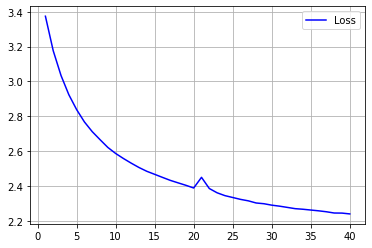

In [42]:
fig, ax = plt.subplots()
ax.plot([i for i in range(1,41)],l, 'blue',label='Loss')
plt.grid()
ax.legend()
plt.show()

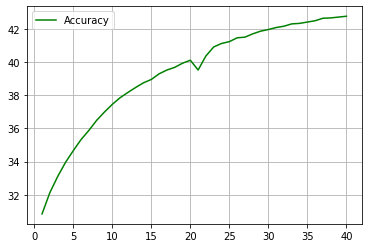

In [43]:
fig, ax = plt.subplots()
ax.plot([i for i in range(1,41)],l1, 'Green',label='Accuracy')
plt.grid()
ax.legend()
plt.show()

In [ ]:
for i in range(995,1000):
    x=plt.imread(imagepath+test_features_keys[i])
    plt.imshow(x)
    plt.show()
    print('Greedy Search:    ',list_sentences[i])
    print('Beam with size 3: ',list_sentences_b_3[i]) 
    print('Beam with size 5: ',list_sentences_b_5[i]) 
    print('Beam with size 7: ',list_sentences_b_7[i]) 
    print('Beam with size 10:',list_sentences_b_10[i]) 

In [44]:
model_incep = InceptionV3(weights='imagenet')
print(model_incep.summary())
model_new = Model(model_incep.input, model_incep.layers[-2].output)

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [45]:
image1 = image.load_img('download.jpg', target_size=(299,299))
image2 = image.img_to_array(image1)
print(image2.shape)
image3 = preprocess_input(image2.reshape( (1,) + image2.shape[:3]))
feature = model_new.predict(image3)

(299, 299, 3)


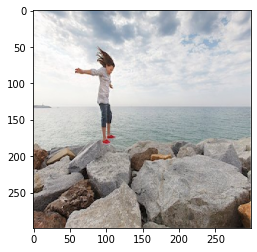

Greedy Search:     two people are sitting on rocks by the water
Beam with size 3:  three people are standing on rock overlooking the ocean
Beam with size 5:  three people are standing on rock overlooking the ocean
Beam with size 7:  two people sit on rocks by the water
Beam with size 10: group of people sit on rock overlooking the ocean


In [46]:
plt.imshow(image1)
plt.show()
print('Greedy Search:    ',greedy_search(feature))
print('Beam with size 3: ',beam_search_predictions(feature,3)) 
print('Beam with size 5: ',beam_search_predictions(feature,5)) 
print('Beam with size 7: ',beam_search_predictions(feature,7)) 
print('Beam with size 10:',beam_search_predictions(feature,10)) 